# Jupyter notebook used for controlling a ROS simulation

## Imports
To begin with, the next block of code is used for importing, once for all, the libraries that will be needed in the following scripts.

In [1]:
import rospy
import actionlib
import tf

from geometry_msgs.msg import Twist
from sensor_msgs.msg import LaserScan
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
from actionlib_msgs.msg import GoalStatusArray
from nav_msgs.msg import Odometry
from tf.transformations import *

import jupyros as jr
from jupyros import ros3d
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from __future__ import print_function

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import math
import time

## User Interface to select the driving modalities

To begin with, it is defined the global variable _driving_mode_ to keep track of the current modality selected by the user. The variable is initialized to the default value _'none'_ since no choice is already taken at this point.

In [2]:
driving_mode = 'none'

In the following are defined the three main buttons with which the user will be able to change the driving modality. Plus, it is also declared an output widget to display the current state of the variable _driving_mode_.

In [3]:
b1 = widgets.Button(description="Autonomous")
b2 = widgets.Button(description="Manual")
b3 = widgets.Button(description="Assisted")
out = widgets.Output(layout={'border':'2px solid black'})

At this point, in the following block of code, are defined the callback functions associated to the buttons.

In [4]:
def b1_clicked(b1):
    global driving_mode
    driving_mode = 'automatic'
    with out:
        out.clear_output()
        print('Driving mode: ', driving_mode)
        
def b2_clicked(b2):
    global driving_mode
    driving_mode = 'manual'
    with out:
        out.clear_output()
        print('Driving mode: ', driving_mode)

def b3_clicked(b3):
    global driving_mode
    driving_mode = 'assisted'
    with out:
        out.clear_output()
        print('Driving mode: ', driving_mode)
        
# Associate to each button its corrispective callback
b1.on_click(b1_clicked)
b2.on_click(b2_clicked)
b3.on_click(b3_clicked)

Finally, here are displayed the three interactive buttons.

In [5]:
widgets.HBox([b1, b2, b3])

And here it is the output window that allows to monitor which is the current modality selected.

In [6]:
display(out)

Output(layout=Layout(border='2px solid black'))

## Implementation of the driving modalities

First of all we initialize a new ros node, called _jupy_ui_.

In [7]:
rospy.init_node('jupy_ui')

In order to move the robot inside the simulation environment, the velocity messages published on the _/cmd_vel_ topic are taken into account. Therefore, first of all, we need to define a publisher to that topic. Then, the purpose of the interface should be choosing which message to publish depending on the driving modality that has been selected.

In [8]:
pub1 = rospy.Publisher('/cmd_vel', Twist, queue_size= 1)

In the next block of code are defined the callback functions to be associated to three subscribers to some custom topics: _/autonomous/cmd_vel_, _/manual/cmd_vel_ and _/assisted/cmd_vel_. The purpose of these topics is not to publish the velocity messages directly on _/cmd_vel_ but rather on some intermediate topics. Then, depending on the driving mode selected, the messages on the corresponding topic can be further published also on _/cmd_vel_.

In [9]:
def auto_callback(msg):
    global driving_mode
    if driving_mode == 'automatic':
        pub1.publish(msg)

def man_callback(msg):
    global driving_mode
    if driving_mode == 'manual':
        pub1.publish(msg)

def ass_callback(msg):
    global driving_mode
    if driving_mode == 'assisted':
        pub1.publish(msg)

Here we finally initialize the subscribers.

In [10]:
sub1 = rospy.Subscriber('/automatic/cmd_vel', Twist, auto_callback)
sub2 = rospy.Subscriber('/manual/cmd_vel', Twist, man_callback)
sub3 = rospy.Subscriber('/assisted/cmd_vel', Twist, ass_callback)

### Autonomous modality interface

When the user selects the autonomous mode through one of the three buttons above, the _move_base_ node expects to receive the goal position to be reached inside the map. Therefore, to send such goal, it is necessary to define an action client. notice that, after its initialization, the client waits for the server that will manage its requests to be available.

In [11]:
client = actionlib.SimpleActionClient('move_base', MoveBaseAction)
client.wait_for_server()

True

At this point, we can define the structure of the goal message. Since some of its parts are constant, it is possible to fill them already.

In [12]:
goal = MoveBaseGoal()
goal.target_pose.header.frame_id = "map"
goal.target_pose.header.stamp = rospy.Time.now()
goal.target_pose.pose.orientation.w = 1.0      

In the next block of code is then defined the function that will be used to send the goal position (x,y).

In [13]:
def send_goal(x, y):
    client.cancel_goal()
    print("Current goal: (", x, ",", y,")")
    goal.target_pose.pose.position.x = x
    goal.target_pose.pose.position.y = y
    client.send_goal(goal)

Finally, here there is the code that allows the user to choose a goal interactively through two sliders. Each time that the user interacts with the widgets, the function _send_goal()_ will be called and a new goal will be sent to the _move_base_ node. Remember that, in order to successfully read the velocity messages that the _move_base_ node will generate, the user should make sure to have previously selected the autonomous mode through the dedicated button.

In [14]:
x_slider = widgets.IntSlider(min=-12, max=12, step=1, value=0, description="Select x:")
y_slider = widgets.IntSlider(min=-12, max=12, step=1, value=0, description="Select y:")
    
interact(send_goal, x=x_slider, y=y_slider);

interactive(children=(IntSlider(value=0, description='Select x:', max=12, min=-12), IntSlider(value=0, descrip…

### Goal's status

In [15]:
reached = 0
not_reached = 0

In [16]:
flag1 = False
flag2 = False

In [17]:
out_goal = widgets.Output(layout={'border':'2px solid black'})

In [18]:
def status_callback(msg):
    global reached, not_reached, flag1, flag2
    
    # get the length of the goals' status list
    l = len(msg.status_list)
    
    if l<=1:  
        # if the goal's status has not been considered already
        if not(flag1):
            status = msg.status_list[l-1].status
            # if SUCCESS (3)
            if status==3:      
                reached += 1 
                flag1 = True
                with out_goal:
                    out_goal.clear_output()
                    print('Reached:     ', reached)
                    print('Not reached: ', not_reached)
                
            # if UNREACHABLE (4)
            if status==4:      
                not_reached += 1 
                flag1 = True
                with out_goal:
                    out_goal.clear_output()
                    print('Reached:     ', reached)
                    print('Not reached: ', not_reached)
                
        # reset flag2       
        flag2 = False
    else:                             
        # if the status of the overwritten goals has not been considered already
        if not(flag2):
            if flag1:
                not_reached = not_reached + l-2
            else:
                not_reached = not_reached + l-1
                
            flag1 = False 
            flag2 = True
            
            with out_goal:
                out_goal.clear_output()
                print('Reached:     ', reached)
                print('Not reached: ', not_reached)

In [19]:
sub = rospy.Subscriber('/move_base/status', GoalStatusArray, status_callback)

In [20]:
display(out_goal)

Output(layout=Layout(border='2px solid black'))

### Manual & Assisted modalities interface

When the user selects the manual or the assisted modalities through the dedicated buttons above, the simulation environment waits for him to directly publish a _Twist_ message. Moreover, in the case of the assisted mode, the message will pass through a further control that will overwrite it in order to avoid collisions, if necessary.

So, whichever is the case, we need an interface that allow the user to publish a _Twist_ message. This can be done by defining some buttons and associating to them a proper callback to publish a message on the _/manual/cmd_vel_ topic. Hence, first of all let's initialize a publisher to such topic. The option _'latch=True'_ is necessary to specify to publish a message continuously on the topic until a different one is specified.

In [21]:
pub2 = rospy.Publisher('/manual/cmd_vel', Twist, queue_size=1, latch=True)

Here we define the callbacks that will be associated to the click of each button.

In [22]:
def b1_clicked(b):
    vel = Twist()
    vel.linear.x = 0.5
    vel.angular.z = 1
    pub2.publish(vel)

def b2_clicked(b):
    vel = Twist()
    vel.linear.x = 1.2
    vel.angular.z = 0
    pub2.publish(vel)

def b3_clicked(b):
    vel = Twist()
    vel.linear.x = 0.5
    vel.angular.z = -1
    pub2.publish(vel)
    
def b4_clicked(b):
    vel = Twist()
    vel.linear.x = 0
    vel.angular.z = 1.2
    pub2.publish(vel)

def b5_clicked(b):
    vel = Twist()
    vel.linear.x = 0
    vel.angular.z = 0
    pub2.publish(vel)

def b6_clicked(b):
    vel = Twist()
    vel.linear.x = 0
    vel.angular.z = -1.2
    pub2.publish(vel)
    
def b7_clicked(b):
    vel = Twist()
    vel.linear.x = -0.5
    vel.angular.z = -1
    pub2.publish(vel)

def b8_clicked(b):
    vel = Twist()
    vel.linear.x = -1.2
    vel.angular.z = 0
    pub2.publish(vel)

def b9_clicked(b):
    vel = Twist()
    vel.linear.x = -0.5
    vel.angular.z = 1
    pub2.publish(vel)

In this block we define the buttons that will form the interface for controlling the robot manually.

In [23]:
b1 = widgets.Button(description='F-L')
b2 = widgets.Button(description='F')
b3 = widgets.Button(description='F-R')

b4 = widgets.Button(description='L')
b5 = widgets.Button(description='STOP')
b6 = widgets.Button(description='R')

b7 = widgets.Button(description='B-L')
b8 = widgets.Button(description='B')
b9 = widgets.Button(description='B-R')

At this point we can associate to each button the callbacks previously defined.

In [24]:
b1.on_click(b1_clicked)
b2.on_click(b2_clicked)
b3.on_click(b3_clicked)
b4.on_click(b4_clicked)
b5.on_click(b5_clicked)
b6.on_click(b6_clicked)
b7.on_click(b7_clicked)
b8.on_click(b8_clicked)
b9.on_click(b9_clicked)

And finally, we display the buttons to interact with.

In [25]:
widgets.VBox([widgets.HBox([b1, b2, b3]), widgets.HBox([b4, b5, b6]), widgets.HBox([b7, b8, b9])])

#### Collision Avoidance Algorithm

After having overwritten the messages coming from the _/manual/cmd_vel_ topic, we want to publish them on the _/assisted/cmd_vel_. Therefore, it is necessary to define a publisher to that topic.
Moreover, in this case, we can avoid using the _jupyros_ library since we do not need a widget to directly define the messages. In fact, it will be a proper function, called _avoid_collision()_, that will do that in charge of the user.

In [26]:
pub3= rospy.Publisher('/assisted/cmd_vel', Twist, queue_size= 1)

In the next block it is defined a global variable that will be used to save the velocity messages from _/manual/cmd_vel_ and modify them, if necessary, to avoid collisions.

In [27]:
ass_vel = Twist()

Here we define another output widget that can be used to display the info about the obstacles retrived by the laser scan.

In [28]:
out_scan = widgets.Output(layout={'border':'2px solid black'})

At this point, we can define the function that is in charge of implementing the actual collision avoidance algorithm: it checks the distance of the robot from the obstacles in the external environment (obtained from the _/scan_ topic) and updates its velocity in order to avoid collisions.

In [29]:
def avoid_collision(regions):
    
    global ass_vel
    
    # save the current linear and angular velocities obtained as the result of the user's input
    linear_x= ass_vel.linear.x
    angular_z= ass_vel.angular.z
    
    state_description = ''

    # update the linear and angular velocities in order to avoid collisions
    if regions['front'] > 0.7 and regions['fleft'] > 0.7 and regions['fright'] > 0.7:
        state_description = 'no obstacle detected'

    elif regions['front'] < 0.7 and regions['fleft'] > 0.7 and regions['fright'] > 0.7:
        state_description = 'obstacle in the front'
        # don't go straight
        if (linear_x > 0) and (angular_z == 0):
            linear_x= 0
            angular_z= 0

    elif regions['front'] > 0.7 and regions['fleft'] > 0.7 and regions['fright'] < 0.7:
        state_description = 'obstacle in the fright'
        # don't turn fright
        if (linear_x > 0) and (angular_z < 0):
            linear_x= 0
            angular_z= 0

    elif regions['front'] > 0.7 and regions['fleft'] < 0.7 and regions['fright'] > 0.7:
        state_description = 'obstacle in the fleft'
        # don't turn fleft
        if (linear_x > 0) and (angular_z > 0):
            linear_x= 0
            angular_z= 0

    elif regions['front'] < 0.7 and regions['fleft'] > 0.7 and regions['fright'] < 0.7:
        state_description = 'obstacle in the front and fright'
        # don't go straight or turn fright
        if (linear_x > 0) and (angular_z <= 0):
            linear_x= 0
            angular_z= 0

    elif regions['front'] < 0.7 and regions['fleft'] < 0.7 and regions['fright'] > 0.7:
        state_description = 'obstacle in the front and fleft'
        # don't go straight or turn fleft
        if (linear_x > 0) and (angular_z >= 0):
            linear_x= 0
            angular_z= 0

    elif regions['front'] < 0.7 and regions['fleft'] < 0.7 and regions['fright'] < 0.7:
        state_description = 'obstacle in the front and fleft and fright'
        # don't go straight, turn fright or fleft
        if (linear_x > 0):
            linear_x= 0
            angular_z= 0

    elif regions['front'] > 0.7 and regions['fleft'] < 0.7 and regions['fright'] < 0.7:
        state_description = 'obstacle in the fleft and fright'
        # don't turn fright or fleft
        if (linear_x > 0) and (angular_z != 0):
            linear_x= 0
            angular_z= 0

    else:
        state_description = 'unknown case'
        rospy.loginfo(regions)

        
    # update the  linear and angular velocities
    ass_vel.linear.x= linear_x
    ass_vel.angular.z= angular_z
    pub3.publish(ass_vel)

Moving further, in the next block of code are defined the callback functions of the two subscribers that are required by the algorithm: one to the _/scan_ topic and the other to the _/manual/cmd_vel_ one.

In [30]:
# /scan callback
def scan_callback(msg):
    regions = {
        'right':  min(min(msg.ranges[0:143]), 10),
        'fright': min(min(msg.ranges[144:287]), 10),
        'front':  min(min(msg.ranges[288:431]), 10),
        'fleft':  min(min(msg.ranges[432:575]), 10),
        'left':   min(min(msg.ranges[576:719]), 10),
    }
    avoid_collision(regions)

# /manual/cmd_vel callback
def copy_vel_callback(msg):  
    global ass_vel
    ass_vel= msg

Finally, we can initialize the two subscribers.

In [31]:
sub4 = rospy.Subscriber('/scan', LaserScan, scan_callback)
sub5 = rospy.Subscriber('/manual/cmd_vel', Twist, copy_vel_callback)

## Plotting both the robot's position and the data from the laser scanner

Define some variables to store the both the data about the robot's position and the ones from the laser scanner with which it is equipped.

In [32]:
loc_map_x, loc_map_y = [], []
glob_map_x, glob_map_y = [], []
pos_x, pos_y = [], []
count = 0

First of all we can build a local map using the data retrieved by the laser scanner mounted on the robot. This map simply consists in computing a cloud of points wrt. the local frame attached to the robot.

In [33]:
def build_localMap(msg):
    global loc_map_x, loc_map_y 
        
    # BUILD THE LOCAL MAP
    th = -np.pi/2           # initial angle 
    d_th = np.pi/90         # incremental step 
    
    # copy the ranges measured by the sensor into a list
    d = msg.ranges
    
    # Save 90 out of the 720 points collected by the laser scanner
    for i in range(0, 720, 8): 
        # compute the coordinates of the i-th point wrt. the local fram
        loc_point_x = d[i] * np.cos(th)
        loc_point_y = d[i] * np.sin(th)
        
        # add the current point the local map
        loc_map_x.append(loc_point_x)
        loc_map_y.append(loc_point_y)
        
        # update the angle covered by the laser scanner
        th = th + d_th

At this point, in order to make the data from the laser scan actually useful, we have to convert the coordinates of the local map's points in the global frame of reference. This can be done by taking into account the pose in which the robot made the measurements, available from the _/odom_ topic.

In [34]:
def build_globalMap(msg):
    global loc_map_x, loc_map_y, glob_map_x, glob_map_y, pos_x, pos_y, count
    count+= 1
    
    # control the dimension of the lists where the robot's x and y position are saved,
    # save only the 500 most updated data
    pos_length = len(pos_x)
    if (pos_length > 500):
        pos_x, pos_y = [], []
        
    # save 1 datum every 10 to avoid the dimension increasing too fast
    if count == 50:
        pos_x.append(msg.pose.pose.position.x)
        pos_y.append(msg.pose.pose.position.y)
        count = 0
    
    # control the dimension of the lists where the global map is saved,
    # save only the 1800 most updated data
    glob_length = len(glob_map_x)
    if (glob_length > 1800):
        glob_map_x, glob_map_y = [], []
        
    # get the quaternion that describe the current orientation of the robot and transform it to a rotational matrix
    q = [msg.pose.pose.orientation.x, msg.pose.pose.orientation.y, msg.pose.pose.orientation.z, msg.pose.pose.orientation.w]
    R = quaternion_matrix(q)
    #print(R)
    
    # get the current position of the robot
    p = [msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.position.z, 1]
    
    loc_length = len(loc_map_x)
    if (loc_length != 0):
        for i in range(0, 90): 
            # move from local to global coordinates
            loc_point = [loc_map_x[loc_length-1-i], loc_map_y[loc_length-1-i], 0, 1]
            glob_point = np.dot(R, loc_point) + p
            #glob_point = quaternion_multiply(quaternion_multiply(q, loc_point), quaternion_conjugate(q)) + p

            # add the current point to the global map
            glob_map_x.append(glob_point[0])
            glob_map_y.append(glob_point[1])
         

Here we define two subscribers:
 - _sub6_: to the _/scan_ topic, in order to collect the points that form the local map;
 - _sub7_: to the _/odom_ topic, in order to transform the coordinates of the collected points in the global frame of reference; 

In [35]:
sub6 = rospy.Subscriber('/scan', LaserScan, build_localMap)
sub7 = rospy.Subscriber('/odom', Odometry, build_globalMap)

In this final block of code we plot the information collected before.

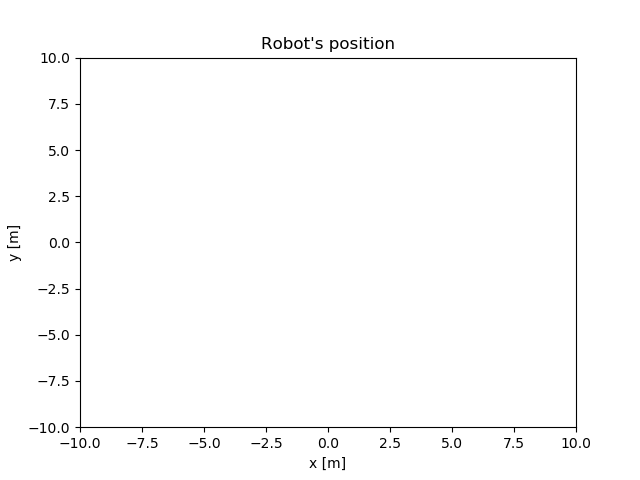

In [36]:
%matplotlib widget

fig = plt.figure()
ax = plt.axes(xlim=(-10, 10), ylim=(-10, 10))
points, = ax.plot([], [], 'ro', linewidth=0.3, markersize=0.3)
line, = ax.plot([], [], lw=2)
plt.title("Robot's position")
plt.xlabel('x [m]')
plt.ylabel('y [m]')

def init():
    line.set_data([], [])
    points.set_data([], [])
    return line, points,

def animate(frame):
    line.set_data(pos_x, pos_y)
    points.set_data(glob_map_x, glob_map_y)
    return line, points,

anim = FuncAnimation(fig, animate, init_func=init)
plt.show()